# Notebook 2: GCN Model Implementation

In this notebook, we will implement the Graph Convolutional Network (GCN) as described in the paper "Semi-Supervised Classification with Graph Convolutional Networks" by Thomas Kipf and Max Welling (2017).

## Learning Objectives

By the end of this notebook, you should be able to:
1. Implement a GCN layer from scratch
2. Understand the renormalization trick and why it's important
3. Build a complete GCN architecture with customizable depth
4. Understand the mathematical foundations of each component

Let's begin by importing the necessary libraries.

In [1]:
import numpy as np
import scipy.sparse as sp
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import os
import sys
from tqdm.notebook import tqdm

# Add the current directory to path for importing utils
sys.path.append('.')
import utils

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)

# Check if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## 1. Understanding the GCN Layer

The core operation in a GCN layer is the graph convolution, which is approximated as:

$$H^{(l+1)} = \sigma(\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}H^{(l)}W^{(l)})$$

where:
- $H^{(l)}$ is the matrix of activations in the $l$-th layer
- $\tilde{A} = A + I$ is the adjacency matrix with self-loops
- $\tilde{D}$ is the degree matrix of $\tilde{A}$ (i.e., $\tilde{D}_{ii} = \sum_j \tilde{A}_{ij}$)
- $W^{(l)}$ is the weight matrix for the $l$-th layer
- $\sigma$ is a non-linear activation function (e.g., ReLU)

Let's implement this as a PyTorch layer:

In [2]:
class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize weights using Glorot (Xavier) initialization
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        stdv = 1. / np.sqrt(in_features)
        self.weight.data.uniform_(-stdv, stdv)
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
            self.bias.data.uniform_(-stdv, stdv)
        else:
            self.register_parameter('bias', None)

    def forward(self, input, adj):
        """
        Forward pass of the GCN layer.
        
        Parameters
        ----------
        input : torch.Tensor
            Input features, shape (N, in_features)
        adj : torch.sparse.FloatTensor
            Normalized adjacency matrix, shape (N, N)
            
        Returns
        -------
        torch.Tensor
            Output features, shape (N, out_features)
        """
        # Linear transformation: H * W (matrix multiplication)
        support = torch.mm(input, self.weight)
        
        # Graph convolution: A * H * W
        # Use torch.spmm for efficient sparse-dense matrix multiplication
        output = torch.spmm(adj, support)
        
        if self.bias is not None:
            return output + self.bias
        else:
            return output
    
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

### Understanding the forward pass

The forward pass of the GCN layer consists of two main operations:

1. **Linear Transformation**: $H^{(l)}W^{(l)}$ - This is a standard linear transformation that maps from `in_features` to `out_features`.

2. **Graph Convolution**: $\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}H^{(l)}W^{(l)}$ - This is achieved by multiplying the preprocessed adjacency matrix with the result of the linear transformation.

The preprocessing of the adjacency matrix (i.e., computing $\tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}$) is done outside the layer to avoid redundant computations.

## 2. The Renormalization Trick

The renormalization trick is a key innovation in the GCN paper. It involves two steps:

1. Adding self-loops to the graph: $\tilde{A} = A + I$
2. Normalizing the adjacency matrix: $\hat{A} = \tilde{D}^{-1/2}\tilde{A}\tilde{D}^{-1/2}$

Why is this important?

- **Self-loops** ensure that a node's own features are considered in the update
- **Normalization** prevents numerical instabilities and exploding/vanishing gradients
- It helps preserve the scale of the feature vectors
- It's equivalent to a specific form of Laplacian smoothing, which helps with generalization

Let's implement this preprocessing step:

In [3]:
def preprocess_adj_tensor(adj):
    """
    Preprocessing of adjacency matrix for GCN model and conversion to PyTorch tensor.
    
    Parameters
    ----------
    adj : scipy.sparse.csr_matrix
        Adjacency matrix
        
    Returns
    -------
    torch.sparse.FloatTensor
        Preprocessed adjacency matrix as a sparse tensor
    """
    # Add self-loops: A_tilde = A + I
    adj_normalized = utils.normalize_adj(adj + sp.eye(adj.shape[0]))
    
    # Convert to tuple representation (coords, values, shape)
    adj_normalized = utils.sparse_to_tuple(adj_normalized)
    
    # Convert to torch tensor
    i = torch.LongTensor(adj_normalized[0].T)
    v = torch.FloatTensor(adj_normalized[1])
    shape = adj_normalized[2]
    
    return torch.sparse.FloatTensor(i, v, torch.Size(shape))

## 3. Building the Complete GCN Architecture

Now let's build a complete GCN model with a customizable number of layers. The original paper used a two-layer GCN with the following architecture:

- First layer: Graph convolution followed by ReLU activation
- Second layer: Graph convolution followed by softmax (for classification)

Let's implement this architecture:

In [4]:
class GCN(nn.Module):
    """
    Graph Convolutional Network with customizable depth.
    """
    def __init__(self, nfeat, nhid, nclass, dropout=0.5, num_layers=2):
        """
        Initialize the GCN model.
        
        Parameters
        ----------
        nfeat : int
            Number of input features
        nhid : int
            Number of hidden units
        nclass : int
            Number of classes (output dimension)
        dropout : float, optional
            Dropout rate
        num_layers : int, optional
            Number of GCN layers
        """
        super(GCN, self).__init__()
        
        self.dropout = dropout
        self.num_layers = num_layers
        
        # Create layers
        if num_layers == 1:
            # Single-layer GCN (rarely used in practice)
            self.layers = nn.ModuleList([GraphConvolution(nfeat, nclass)])
        else:
            # Multi-layer GCN
            self.layers = nn.ModuleList([
                GraphConvolution(nfeat, nhid)  # Input layer
            ])
            
            # Add hidden layers if more than 2 layers
            for i in range(num_layers - 2):
                self.layers.append(GraphConvolution(nhid, nhid))
                
            # Add output layer
            self.layers.append(GraphConvolution(nhid, nclass))

    def forward(self, x, adj):
        """
        Forward pass of the GCN model.
        
        Parameters
        ----------
        x : torch.Tensor
            Input features
        adj : torch.sparse.FloatTensor
            Normalized adjacency matrix
            
        Returns
        -------
        torch.Tensor
            Output predictions
        """
        # Forward pass through all layers except the last one
        for i in range(self.num_layers - 1):
            x = self.layers[i](x, adj)
            x = F.relu(x)  # Apply ReLU activation
            x = F.dropout(x, self.dropout, training=self.training)  # Apply dropout
        
        # Final layer (no activation or dropout)
        x = self.layers[-1](x, adj)
        
        return F.log_softmax(x, dim=1)  # Apply log softmax for classification

### Understanding the Forward Pass in the GCN Model

The forward pass of the GCN model consists of:

1. For each layer except the last one:
   - Apply graph convolution
   - Apply ReLU activation
   - Apply dropout (for regularization)

2. For the last layer:
   - Apply graph convolution
   - Apply log softmax (for classification)

The mathematical formula for a 2-layer GCN is:

$$Z = \text{softmax}(\hat{A} \, \text{ReLU}(\hat{A} X W^{(0)}) \, W^{(1)})$$

where:
- $X$ is the input feature matrix
- $\hat{A}$ is the normalized adjacency matrix with self-loops
- $W^{(0)}$ and $W^{(1)}$ are the weight matrices for the first and second layers

## 4. Working with Sparse Matrices and PyTorch

In graph-based tasks, the adjacency matrix is typically very sparse (most entries are zero). To efficiently work with such matrices, we use sparse matrix representations. Let's create functions to convert between different sparse formats:

In [5]:
def sparse_mx_to_torch_sparse_tensor(sparse_mx):
    """
    Convert a scipy sparse matrix to a torch sparse tensor.
    """
    sparse_mx = sparse_mx.tocoo().astype(np.float32)
    indices = torch.from_numpy(
        np.vstack((sparse_mx.row, sparse_mx.col)).astype(np.int64))
    values = torch.from_numpy(sparse_mx.data)
    shape = torch.Size(sparse_mx.shape)
    return torch.sparse.FloatTensor(indices, values, shape)

## 5. Putting It All Together: Example Usage

Let's create a simple example to demonstrate how to use our GCN implementation:

In [6]:
# Load the Cora dataset
adj, features, labels, idx_train, idx_val, idx_test = utils.load_data(dataset="cora")

# Convert to torch tensors
features = utils.sparse_mx_to_torch_sparse_tensor(features)
adj = utils.sparse_mx_to_torch_sparse_tensor(utils.preprocess_adj(adj))
labels = torch.LongTensor(labels)

# Create a small example GCN with 2 layers
# Input dimension: number of features (1433 for Cora)
# Hidden dimension: 16 (as in the paper)
# Output dimension: number of classes (7 for Cora)
model = GCN(nfeat=features.shape[1], 
            nhid=16, 
            nclass=len(torch.unique(labels)),
            dropout=0.5)

print(model)

# Generate predictions
model.eval()  # Set the model to evaluation mode
with torch.no_grad():
    output = model(features, adj)

print(f"Input shape: {features.shape}")
print(f"Output shape: {output.shape}")
print(f"First few predictions:\n{output[:5]}")

GCN(
  (layers): ModuleList(
    (0): GraphConvolution (1433 -> 16)
    (1): GraphConvolution (16 -> 7)
  )
)
Input shape: torch.Size([2708, 1433])
Output shape: torch.Size([2708, 7])
First few predictions:
tensor([[-2.0886, -1.8160, -1.8652, -2.0528, -1.8550, -2.0031, -1.9744],
        [-2.0919, -1.8255, -1.8529, -2.0757, -1.8311, -2.0117, -1.9721],
        [-2.0810, -1.8233, -1.8696, -2.0686, -1.8418, -2.0010, -1.9702],
        [-2.0874, -1.8231, -1.8677, -2.0619, -1.8460, -2.0010, -1.9682],
        [-2.0702, -1.8091, -1.8823, -2.0358, -1.8413, -2.0054, -2.0099]])


/home/jupyter-st125462/RTML/Arya_Presents_GCN_GAT/GCN/utils.py:180: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:644.)
  return torch.sparse.FloatTensor(indices, values, shape)


## 6. Visualizing the GCN Architecture

Let's create a simple visualization of our GCN architecture:

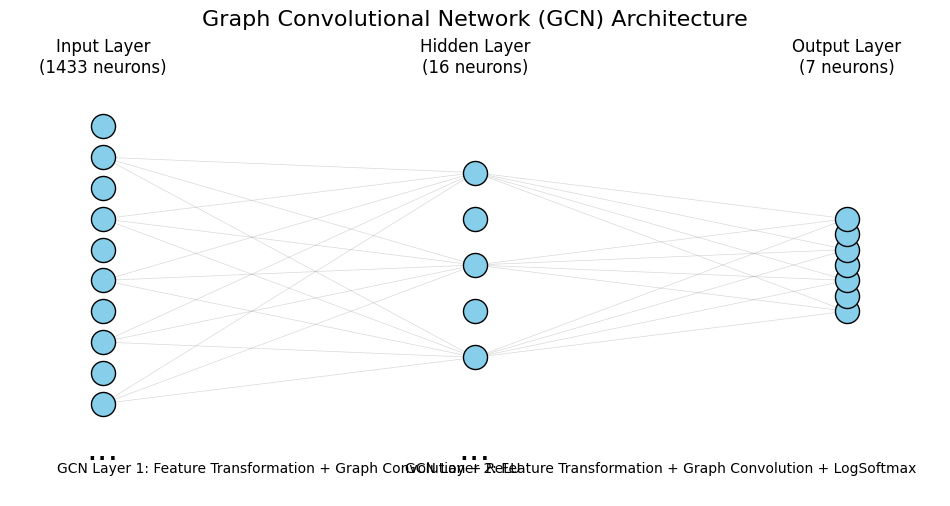

In [7]:
def visualize_gcn_architecture(input_dim, hidden_dim, output_dim):
    """
    Visualize the GCN architecture.
    """
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Define layer positions
    layer_positions = [0.1, 0.5, 0.9]  # Input, hidden, output
    layer_labels = ['Input Layer', 'Hidden Layer', 'Output Layer']
    layer_dims = [input_dim, hidden_dim, output_dim]
    node_positions = {
        0: np.linspace(0.2, 0.8, min(input_dim, 10)),  # Show at most 10 nodes
        1: np.linspace(0.3, 0.7, min(hidden_dim, 5)),  # Show at most 5 nodes
        2: np.linspace(0.4, 0.6, min(output_dim, 7))   # Show at most 7 nodes
    }
    
    # Draw nodes
    for i, (pos_x, label, dim) in enumerate(zip(layer_positions, layer_labels, layer_dims)):
        # Draw nodes
        pos_y = node_positions[i]
        num_visible = len(pos_y)
        
        if dim > num_visible:
            # Draw visible nodes
            ax.scatter([pos_x] * num_visible, pos_y, s=300, c='skyblue', edgecolors='black', zorder=2)
            
            # Draw dots to indicate more nodes
            ax.text(pos_x, 0.1, "...", fontsize=24, ha='center', va='center')
        else:
            # Draw all nodes
            ax.scatter([pos_x] * dim, pos_y, s=300, c='skyblue', edgecolors='black', zorder=2)
        
        # Add layer label
        ax.text(pos_x, 0.95, f"{label}\n({dim} neurons)", fontsize=12, ha='center', va='center')
        
        # Draw connections to next layer
        if i < len(layer_positions) - 1:
            next_pos_x = layer_positions[i+1]
            next_pos_y = node_positions[i+1]
            
            # Draw a sample of connections (not all to avoid clutter)
            for y1 in pos_y[::2]:  # Take every other node
                for y2 in next_pos_y[::2]:  # Take every other node
                    ax.plot([pos_x, next_pos_x], [y1, y2], 'gray', alpha=0.3, linewidth=0.5, zorder=1)
    
    # Add GCN-specific information
    ax.text(0.3, 0.05, "GCN Layer 1: Feature Transformation + Graph Convolution + ReLU", fontsize=10, ha='center')
    ax.text(0.7, 0.05, "GCN Layer 2: Feature Transformation + Graph Convolution + LogSoftmax", fontsize=10, ha='center')
    
    # Customize plot
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1)
    ax.set_title("Graph Convolutional Network (GCN) Architecture", fontsize=16)
    ax.axis('off')
    
    return fig

# Visualize GCN architecture for Cora dataset
visualize_gcn_architecture(input_dim=1433, hidden_dim=16, output_dim=7)
plt.show()

## 7. Summary and Next Steps

In this notebook, we've implemented the core components of Graph Convolutional Networks (GCNs):

1. **GCN Layer**: We implemented the graph convolution operation, which combines feature transformation with message passing through the graph structure.

2. **Renormalization Trick**: We explored the importance of adding self-loops and normalizing the adjacency matrix for stable training.

3. **Complete GCN Architecture**: We built a flexible GCN model with customizable depth, following the design in the original paper.

4. **Sparse Matrix Operations**: We learned how to efficiently work with sparse matrices in PyTorch.

Next, we'll focus on training and evaluating our GCN model on a citation network dataset.

## Questions for Understanding

1. How is the graph convolution operation different from a standard convolution in CNNs?
2. Why do we add self-loops to the adjacency matrix before performing the graph convolution?
3. What role does the degree matrix play in the renormalization trick?
4. How would you modify the GCN architecture to handle node regression tasks instead of classification?
5. What are the advantages of using sparse matrix operations when working with graphs?

## 1. Loading and Preprocessing the Cora Dataset

We had a brief look at the Cora dataset. Let's now load it properly and prepare it for training.

In [8]:
# Load the Cora dataset
adj, features, labels, idx_train, idx_val, idx_test = utils.load_data(dataset="cora")

# Convert to PyTorch tensors and move to device
features = utils.sparse_mx_to_torch_sparse_tensor(features).to(device)
adj = utils.sparse_mx_to_torch_sparse_tensor(utils.preprocess_adj(adj)).to(device)
labels = torch.LongTensor(labels).to(device)
idx_train = torch.LongTensor(idx_train).to(device)
idx_val = torch.LongTensor(idx_val).to(device)
idx_test = torch.LongTensor(idx_test).to(device)

# Dataset information
print(f"Dataset: Cora")
print(f"Number of nodes: {adj.shape[0]}")
print(f"Number of edges: {adj._indices().shape[1] // 2}")  # Divide by 2 because the graph is undirected
print(f"Number of features: {features.shape[1]}")
print(f"Number of classes: {len(torch.unique(labels))}")
print(f"Number of training nodes: {len(idx_train)}")
print(f"Number of validation nodes: {len(idx_val)}")
print(f"Number of test nodes: {len(idx_test)}")

Dataset: Cora
Number of nodes: 2708
Number of edges: 6632
Number of features: 1433
Number of classes: 7
Number of training nodes: 140
Number of validation nodes: 500
Number of test nodes: 1000


### Visualizing the Dataset

Let's visualize the training, validation, and test splits to better understand the semi-supervised learning setup.

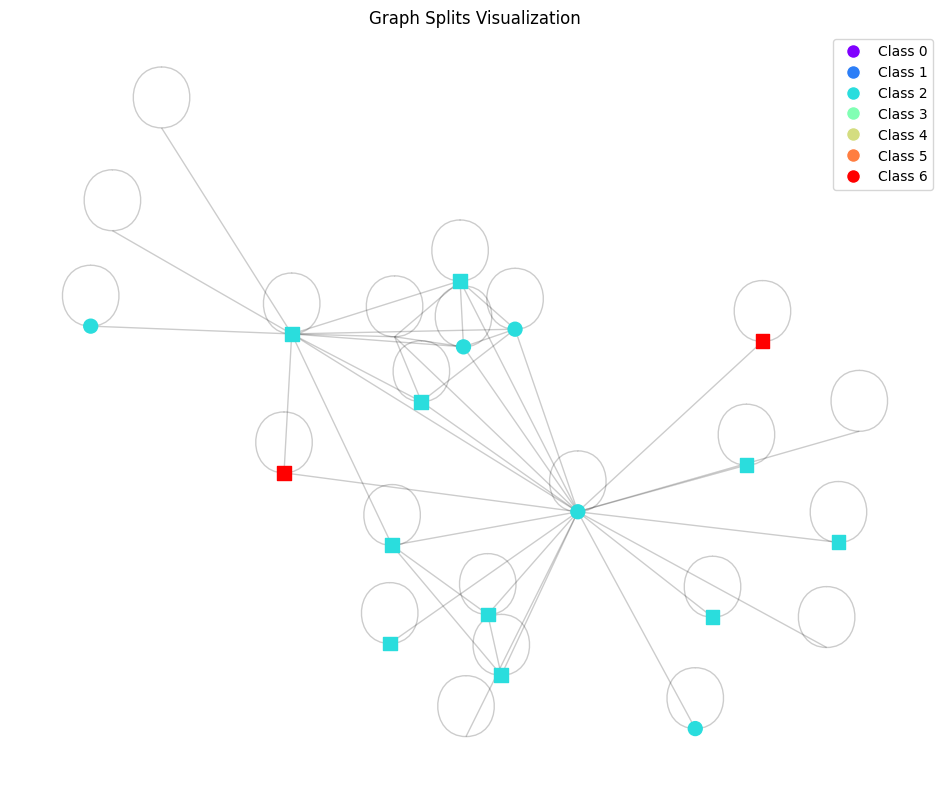

In [13]:
def visualize_splits(adj, labels, idx_train, idx_val, idx_test, max_nodes=100):
    """
    Visualize the training, validation, and test splits of a graph
    
    Parameters:
    -----------
    adj : torch.Tensor
        Adjacency matrix
    labels : torch.Tensor
        Node labels
    idx_train : torch.Tensor
        Training set indices
    idx_val : torch.Tensor
        Validation set indices
    idx_test : torch.Tensor
        Test set indices
    max_nodes : int
        Maximum number of nodes to visualize
    
    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure containing the visualization
    """
    import matplotlib.pyplot as plt
    import networkx as nx
    import numpy as np
    import torch
    
    # Make sure all tensors are on CPU
    adj = adj.cpu()
    labels = labels.cpu()
    idx_train = idx_train.cpu()
    idx_val = idx_val.cpu()
    idx_test = idx_test.cpu()
    
    # Convert adjacency matrix to NetworkX graph
    G = nx.from_numpy_array(adj.to_dense().numpy())
    
    # Get a connected subgraph
    if G.number_of_nodes() > max_nodes:
        # Start from a training node
        start_node = idx_train[0].item()
        # Get nodes within 2 hops
        nodes = set([start_node])
        current = set([start_node])
        for _ in range(2):  # 2 hops
            next_nodes = set()
            for node in current:
                next_nodes.update(G.neighbors(node))
            nodes.update(next_nodes)
            current = next_nodes
            if len(nodes) > max_nodes:
                break
        # Take first max_nodes nodes
        nodes = list(nodes)[:max_nodes]
        # Create subgraph
        G = G.subgraph(nodes)
    
    # Get positions
    pos = nx.spring_layout(G, seed=42)
    
    # Get node sets - use the CPU tensors
    train_nodes = [node for node in G.nodes() if node in idx_train.numpy()]
    val_nodes = [node for node in G.nodes() if node in idx_val.numpy()]
    test_nodes = [node for node in G.nodes() if node in idx_test.numpy()]
    
    # Get color for each class
    num_classes = len(torch.unique(labels))
    class_colors = plt.cm.rainbow(np.linspace(0, 1, num_classes))
    
    # Create figure
    plt.figure(figsize=(12, 10))
    
    # Draw edges
    nx.draw_networkx_edges(G, pos, alpha=0.2)
    
    # Draw nodes by class (color) and split (shape)
    node_colors = {}
    for node in G.nodes():
        node_class = labels[node].item()
        node_colors[node] = class_colors[node_class]
    
    # Draw training nodes (circles)
    if train_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=train_nodes, node_color=[node_colors[n] for n in train_nodes],
                              node_shape='o', node_size=100, label='Train')
    
    # Draw validation nodes (squares)
    if val_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=val_nodes, node_color=[node_colors[n] for n in val_nodes],
                              node_shape='s', node_size=100, label='Validation')
    
    # Draw test nodes (triangles)
    if test_nodes:
        nx.draw_networkx_nodes(G, pos, nodelist=test_nodes, node_color=[node_colors[n] for n in test_nodes],
                              node_shape='^', node_size=100, label='Test')
    
    # Create legend
    plt.legend()
    
    # Create a separate legend for classes
    class_legend_elements = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=class_colors[i],
                                      markersize=10, label=f'Class {i}')
                           for i in range(num_classes)]
    plt.legend(handles=class_legend_elements, loc='upper right')
    
    plt.title("Graph Splits Visualization")
    plt.axis('off')
    
    return plt.gcf()

# Visualize the dataset splits
visualize_splits(adj, labels, idx_train, idx_val, idx_test)
plt.show()

## 2. Importing the GCN Model

Let's import the GCN model we created in the previous notebook. If you've defined it in a separate file, you can import it. Otherwise, we can redefine it here:

In [14]:
# Import the GCN implementation above
# If you've saved it as a separate module, import it like this:
# from gcn_model import GraphConvolution, GCN

# Otherwise, redefine it here:
class GraphConvolution(nn.Module):
    """
    Simple GCN layer, similar to https://arxiv.org/abs/1609.02907
    """
    def __init__(self, in_features, out_features, bias=True):
        super(GraphConvolution, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        # Initialize weights using Glorot (Xavier) initialization
        self.weight = nn.Parameter(torch.FloatTensor(in_features, out_features))
        stdv = 1. / np.sqrt(in_features)
        self.weight.data.uniform_(-stdv, stdv)
        
        if bias:
            self.bias = nn.Parameter(torch.FloatTensor(out_features))
            self.bias.data.uniform_(-stdv, stdv)
        else:
            self.register_parameter('bias', None)

    def forward(self, input, adj):
        """
        Forward pass of the GCN layer.
        
        Parameters
        ----------
        input : torch.Tensor
            Input features, shape (N, in_features)
        adj : torch.sparse.FloatTensor
            Normalized adjacency matrix, shape (N, N)
            
        Returns
        -------
        torch.Tensor
            Output features, shape (N, out_features)
        """
        # Linear transformation: H * W (matrix multiplication)
        support = torch.mm(input, self.weight)
        
        # Graph convolution: A * H * W
        # Use torch.spmm for efficient sparse-dense matrix multiplication
        output = torch.spmm(adj, support)
        
        if self.bias is not None:
            return output + self.bias
        else:
            return output
    
    def __repr__(self):
        return self.__class__.__name__ + ' (' \
               + str(self.in_features) + ' -> ' \
               + str(self.out_features) + ')'

class GCN(nn.Module):
    """
    Graph Convolutional Network with customizable depth.
    """
    def __init__(self, nfeat, nhid, nclass, dropout=0.5, num_layers=2):
        """
        Initialize the GCN model.
        
        Parameters
        ----------
        nfeat : int
            Number of input features
        nhid : int
            Number of hidden units
        nclass : int
            Number of classes (output dimension)
        dropout : float, optional
            Dropout rate
        num_layers : int, optional
            Number of GCN layers
        """
        super(GCN, self).__init__()
        
        self.dropout = dropout
        self.num_layers = num_layers
        
        # Create layers
        if num_layers == 1:
            # Single-layer GCN (rarely used in practice)
            self.layers = nn.ModuleList([GraphConvolution(nfeat, nclass)])
        else:
            # Multi-layer GCN
            self.layers = nn.ModuleList([
                GraphConvolution(nfeat, nhid)  # Input layer
            ])
            
            # Add hidden layers if more than 2 layers
            for i in range(num_layers - 2):
                self.layers.append(GraphConvolution(nhid, nhid))
                
            # Add output layer
            self.layers.append(GraphConvolution(nhid, nclass))

    def forward(self, x, adj):
        """
        Forward pass of the GCN model.
        
        Parameters
        ----------
        x : torch.Tensor
            Input features
        adj : torch.sparse.FloatTensor
            Normalized adjacency matrix
            
        Returns
        -------
        torch.Tensor
            Output predictions
        """
        # Forward pass through all layers except the last one
        for i in range(self.num_layers - 1):
            x = self.layers[i](x, adj)
            x = F.relu(x)  # Apply ReLU activation
            x = F.dropout(x, self.dropout, training=self.training)  # Apply dropout
        
        # Final layer (no activation or dropout)
        x = self.layers[-1](x, adj)
        
        return F.log_softmax(x, dim=1)  # Apply log softmax for classification

Now let's implement the training loop for our GCN model. We'll use the negative log-likelihood loss (NLL loss) for the classification task and the Adam optimizer for parameter updates.

In [15]:
# Initialize the model
model = GCN(nfeat=features.shape[1],
            nhid=16,  # Hidden dimension as in the original paper
            nclass=len(torch.unique(labels)),
            dropout=0.5).to(device)

# Define loss function and optimizer
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

print(model)

GCN(
  (layers): ModuleList(
    (0): GraphConvolution (1433 -> 16)
    (1): GraphConvolution (16 -> 7)
  )
)


### Training Function

Let's define a function to train the model for one epoch:

In [16]:
def train(model, features, adj, labels, idx_train, optimizer, criterion):
    """
    Train the model for one epoch.
    
    Parameters
    ----------
    model : GCN
        The model to train
    features : torch.sparse.FloatTensor
        Input features
    adj : torch.sparse.FloatTensor
        Normalized adjacency matrix
    labels : torch.LongTensor
        Ground-truth labels
    idx_train : torch.LongTensor
        Indices of training nodes
    optimizer : torch.optim.Optimizer
        The optimizer
    criterion : torch.nn.Module
        The loss function
        
    Returns
    -------
    float
        Training loss
    float
        Training accuracy
    """
    model.train()  # Set the model to training mode
    optimizer.zero_grad()  # Clear gradients
    
    # Forward pass
    output = model(features, adj)
    
    # Calculate loss (only on training nodes)
    loss = criterion(output[idx_train], labels[idx_train])
    
    # Backward pass and optimize
    loss.backward()
    optimizer.step()
    
    # Calculate accuracy
    _, preds = output[idx_train].max(1)
    correct = preds.eq(labels[idx_train]).double()
    accuracy = correct.sum() / len(idx_train)
    
    return loss.item(), accuracy.item()

### Evaluation Function

Let's also define a function to evaluate the model:

In [17]:
def evaluate(model, features, adj, labels, idx, criterion):
    """
    Evaluate the model.
    
    Parameters
    ----------
    model : GCN
        The model to evaluate
    features : torch.sparse.FloatTensor
        Input features
    adj : torch.sparse.FloatTensor
        Normalized adjacency matrix
    labels : torch.LongTensor
        Ground-truth labels
    idx : torch.LongTensor
        Indices of nodes to evaluate on
    criterion : torch.nn.Module
        The loss function
        
    Returns
    -------
    float
        Loss
    float
        Accuracy
    """
    model.eval()  # Set the model to evaluation mode
    
    with torch.no_grad():
        # Forward pass
        output = model(features, adj)
        
        # Calculate loss
        loss = criterion(output[idx], labels[idx])
        
        # Calculate accuracy
        _, preds = output[idx].max(1)
        correct = preds.eq(labels[idx]).double()
        accuracy = correct.sum() / len(idx)
    
    return loss.item(), accuracy.item()

### Training Loop

Now let's put it all together in a training loop:

In [18]:
def train_model(model, features, adj, labels, idx_train, idx_val, optimizer, criterion, epochs=200, patience=10, verbose=True):
    """
    Train the model for the specified number of epochs.
    
    Parameters
    ----------
    model : GCN
        The model to train
    features : torch.sparse.FloatTensor
        Input features
    adj : torch.sparse.FloatTensor
        Normalized adjacency matrix
    labels : torch.LongTensor
        Ground-truth labels
    idx_train : torch.LongTensor
        Indices of training nodes
    idx_val : torch.LongTensor
        Indices of validation nodes
    optimizer : torch.optim.Optimizer
        The optimizer
    criterion : torch.nn.Module
        The loss function
    epochs : int, optional
        Number of epochs to train for
    patience : int, optional
        Early stopping patience
    verbose : bool, optional
        Whether to print progress
        
    Returns
    -------
    dict
        Training history
    """
    # Initialize variables
    best_val_acc = 0
    best_epoch = 0
    counter = 0  # For early stopping
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }
    
    # Create progress bar
    pbar = tqdm(range(epochs), desc="Training", disable=not verbose)
    
    # Training loop
    for epoch in pbar:
        # Train for one epoch
        train_loss, train_acc = train(model, features, adj, labels, idx_train, optimizer, criterion)
        
        # Evaluate on validation set
        val_loss, val_acc = evaluate(model, features, adj, labels, idx_val, criterion)
        
        # Save history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # Update progress bar
        pbar.set_postfix({
            'train_loss': f"{train_loss:.4f}",
            'train_acc': f"{train_acc:.4f}",
            'val_loss': f"{val_loss:.4f}",
            'val_acc': f"{val_acc:.4f}"
        })
        
        # Check for improvement
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_epoch = epoch
            counter = 0
            # Save best model
            torch.save(model.state_dict(), 'best_model.pth')
        else:
            counter += 1
        
        # Early stopping
        if counter >= patience:
            if verbose:
                print(f"Early stopping at epoch {epoch}. Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
            break
    
    if verbose:
        print(f"Training finished. Best validation accuracy: {best_val_acc:.4f} at epoch {best_epoch}")
    
    # Load best model
    model.load_state_dict(torch.load('best_model.pth'))
    
    return history

# Train the model
history = train_model(model, features, adj, labels, idx_train, idx_val, optimizer, criterion, epochs=200)

Training:   0%|          | 0/200 [00:00<?, ?it/s]

Early stopping at epoch 38. Best validation accuracy: 0.8400 at epoch 28
Training finished. Best validation accuracy: 0.8400 at epoch 28


## 4. Evaluating the Model

Now that we've trained our model, let's evaluate it on the test set:

In [19]:
# Evaluate on test set
test_loss, test_acc = evaluate(model, features, adj, labels, idx_test, criterion)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

Test Loss: 0.8428
Test Accuracy: 0.7570


### Visualizing Training Progress

Let's visualize the training progress:

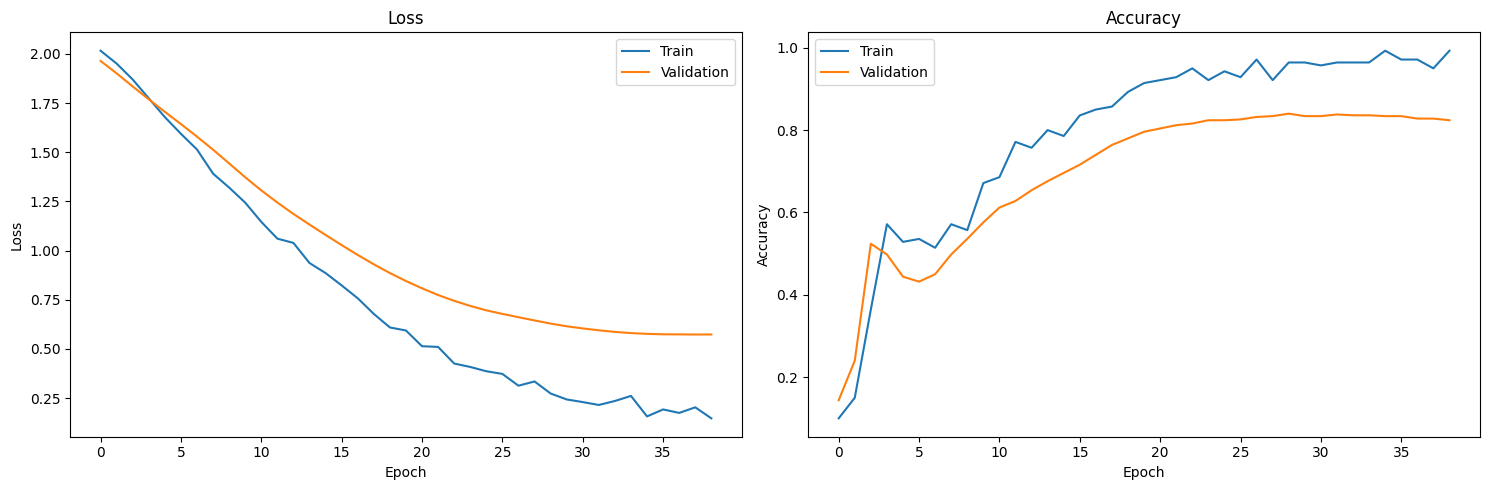

In [20]:
def plot_training_history(history):
    """
    Plot training and validation loss and accuracy.
    
    Parameters
    ----------
    history : dict
        Training history
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Plot loss
    ax1.plot(history['train_loss'], label='Train')
    ax1.plot(history['val_loss'], label='Validation')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.set_title('Loss')
    ax1.legend()
    
    # Plot accuracy
    ax2.plot(history['train_acc'], label='Train')
    ax2.plot(history['val_acc'], label='Validation')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.set_title('Accuracy')
    ax2.legend()
    
    plt.tight_layout()
    return fig

# Plot training history
plot_training_history(history)
plt.show()

### Confusion Matrix

Let's create a confusion matrix to better understand the model's performance:

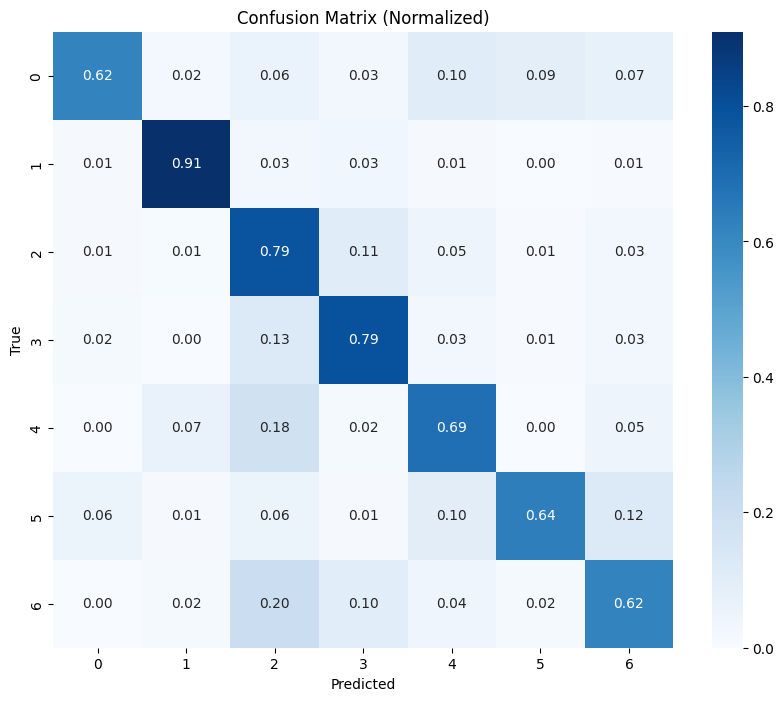

In [21]:
def plot_confusion_matrix(model, features, adj, labels, idx):
    """
    Plot confusion matrix.
    
    Parameters
    ----------
    model : GCN
        The model to evaluate
    features : torch.sparse.FloatTensor
        Input features
    adj : torch.sparse.FloatTensor
        Normalized adjacency matrix
    labels : torch.LongTensor
        Ground-truth labels
    idx : torch.LongTensor
        Indices of nodes to evaluate on
    """
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    model.eval()
    with torch.no_grad():
        # Get predictions
        output = model(features, adj)
        _, preds = output[idx].max(1)
        
        # Convert to numpy
        y_true = labels[idx].cpu().numpy()
        y_pred = preds.cpu().numpy()
        
        # Calculate confusion matrix
        cm = confusion_matrix(y_true, y_pred)
        
        # Normalize by row
        cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        
        # Plot
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix (Normalized)')
        
        return plt.gcf()

# Plot confusion matrix
plot_confusion_matrix(model, features, adj, labels, idx_test)
plt.show()

To better understand the performance of our GCN, let's compare it with some baseline methods:

1. **Random Classifier**: Assigns labels randomly
2. **Majority Classifier**: Always predicts the most common class
3. **MLP (Multi-Layer Perceptron)**: Uses only node features, ignoring graph structure
4. **Label Propagation**: Uses only graph structure, ignoring node features

Test Accuracy Comparison:
Random Classifier: 0.1429
Majority Classifier: 0.2950
MLP (features only): 0.4410
Label Propagation (graph only): 0.6120
GCN (features + graph): 0.7570


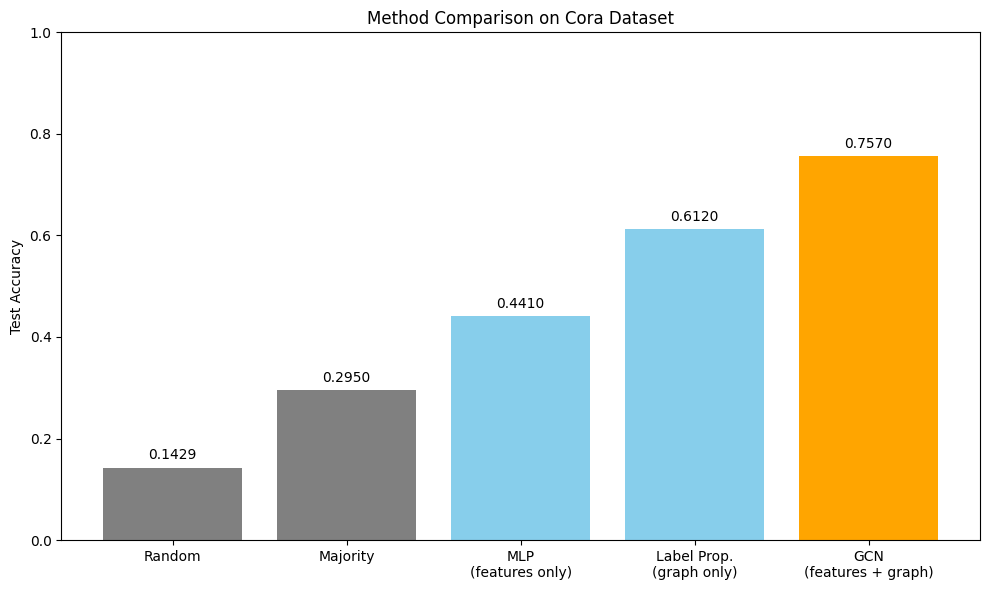

In [22]:
def train_and_evaluate_mlp(features, labels, idx_train, idx_val, idx_test, hidden_dim=16, dropout=0.5, lr=0.01, weight_decay=5e-4, epochs=200, patience=10):
    """
    Train and evaluate a Multi-Layer Perceptron (MLP) as a baseline.
    """
    class MLP(nn.Module):
        def __init__(self, nfeat, nhid, nclass, dropout):
            super(MLP, self).__init__()
            self.fc1 = nn.Linear(nfeat, nhid)
            self.fc2 = nn.Linear(nhid, nclass)
            self.dropout = dropout
            
        def forward(self, x):
            x = F.relu(self.fc1(x))
            x = F.dropout(x, self.dropout, training=self.training)
            x = self.fc2(x)
            return F.log_softmax(x, dim=1)
    
    # Convert sparse features to dense
    if isinstance(features, torch.sparse.FloatTensor):
        features_dense = features.to_dense()
    else:
        features_dense = features
    
    # Initialize model
    model = MLP(features_dense.shape[1], hidden_dim, len(torch.unique(labels)), dropout).to(device)
    
    # Define loss function and optimizer
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    # Variables for early stopping
    best_val_acc = 0
    counter = 0
    
    # Training loop
    for epoch in range(epochs):
        # Train
        model.train()
        optimizer.zero_grad()
        output = model(features_dense)
        loss = criterion(output[idx_train], labels[idx_train])
        loss.backward()
        optimizer.step()
        
        # Evaluate
        model.eval()
        with torch.no_grad():
            output = model(features_dense)
            
            # Validation
            val_loss = criterion(output[idx_val], labels[idx_val])
            _, val_preds = output[idx_val].max(1)
            val_acc = val_preds.eq(labels[idx_val]).double().sum() / len(idx_val)
            
            # Check for improvement
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                counter = 0
                # Save best model
                torch.save(model.state_dict(), 'best_mlp.pth')
            else:
                counter += 1
            
            # Early stopping
            if counter >= patience:
                break
    
    # Load best model
    model.load_state_dict(torch.load('best_mlp.pth'))
    
    # Evaluate on test set
    model.eval()
    with torch.no_grad():
        output = model(features_dense)
        _, test_preds = output[idx_test].max(1)
        test_acc = test_preds.eq(labels[idx_test]).double().sum() / len(idx_test)
    
    return test_acc.item()

def label_propagation(adj, labels, idx_train, idx_test, alpha=0.9, max_iter=100):
    """
    Simple label propagation algorithm as a baseline.
    
    Parameters
    ----------
    adj : torch.sparse.FloatTensor
        Adjacency matrix
    labels : torch.LongTensor
        Ground-truth labels
    idx_train : torch.LongTensor
        Indices of training nodes
    idx_test : torch.LongTensor
        Indices of test nodes
    alpha : float, optional
        Clamping factor
    max_iter : int, optional
        Maximum number of iterations
        
    Returns
    -------
    float
        Test accuracy
    """
    # Convert adjacency to dense
    if hasattr(adj, 'to_dense'):
        A = adj.to_dense().cpu().numpy()
    else:
        A = adj.cpu().numpy()
    
    # Normalize adjacency matrix by row
    D_inv = np.diag(1.0 / np.sum(A, axis=1))
    A_norm = D_inv @ A
    
    # Initialize label matrix
    num_nodes = A.shape[0]
    num_classes = len(torch.unique(labels))
    Y = np.zeros((num_nodes, num_classes))
    
    # Set known labels
    labels_np = labels.cpu().numpy()
    idx_train_np = idx_train.cpu().numpy()
    for i in idx_train_np:
        Y[i, labels_np[i]] = 1
    
    # Original known labels (will remain unchanged)
    Y_0 = Y.copy()
    
    # Label propagation
    for _ in range(max_iter):
        # Propagate labels
        Y = alpha * A_norm @ Y + (1 - alpha) * Y_0
        
        # Clamp known labels
        for i in idx_train_np:
            Y[i] = Y_0[i]
    
    # Get predicted labels
    predictions = np.argmax(Y, axis=1)
    
    # Evaluate on test set
    idx_test_np = idx_test.cpu().numpy()
    test_acc = np.mean(predictions[idx_test_np] == labels_np[idx_test_np])
    
    return test_acc

# Compute baseline accuracies
num_classes = len(torch.unique(labels))
test_size = len(idx_test)

# Random classifier
random_acc = 1.0 / num_classes  # Expected accuracy for random guessing

# Majority classifier
label_counts = torch.bincount(labels)
majority_class = torch.argmax(label_counts).item()
majority_acc = torch.sum(labels[idx_test] == majority_class).item() / test_size

# MLP (using only features, ignoring graph structure)
mlp_acc = train_and_evaluate_mlp(features, labels, idx_train, idx_val, idx_test)

# Label Propagation (using only graph structure, ignoring features)
lp_acc = label_propagation(adj, labels, idx_train, idx_test)

# GCN (our model, using both features and graph structure)
gcn_acc = test_acc  # From our previous evaluation

# Print results
print("Test Accuracy Comparison:")
print(f"Random Classifier: {random_acc:.4f}")
print(f"Majority Classifier: {majority_acc:.4f}")
print(f"MLP (features only): {mlp_acc:.4f}")
print(f"Label Propagation (graph only): {lp_acc:.4f}")
print(f"GCN (features + graph): {gcn_acc:.4f}")

# Plot comparison
methods = ['Random', 'Majority', 'MLP\n(features only)', 'Label Prop.\n(graph only)', 'GCN\n(features + graph)']
accuracies = [random_acc, majority_acc, mlp_acc, lp_acc, gcn_acc]

plt.figure(figsize=(10, 6))
bars = plt.bar(methods, accuracies, color=['gray', 'gray', 'skyblue', 'skyblue', 'orange'])
plt.ylabel('Test Accuracy')
plt.title('Method Comparison on Cora Dataset')
plt.ylim(0, 1)

# Add accuracy values on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.4f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

## 6. Analysis of Node Misclassifications

Let's analyze which nodes are most frequently misclassified:

Number of misclassified test nodes: 243 out of 1000 (24.30%)
Average degree of correctly classified nodes: 0.90
Average degree of misclassified nodes: 0.92
Average neighborhood label homogeneity of correctly classified nodes: 0.93
Average neighborhood label homogeneity of misclassified nodes: 0.72


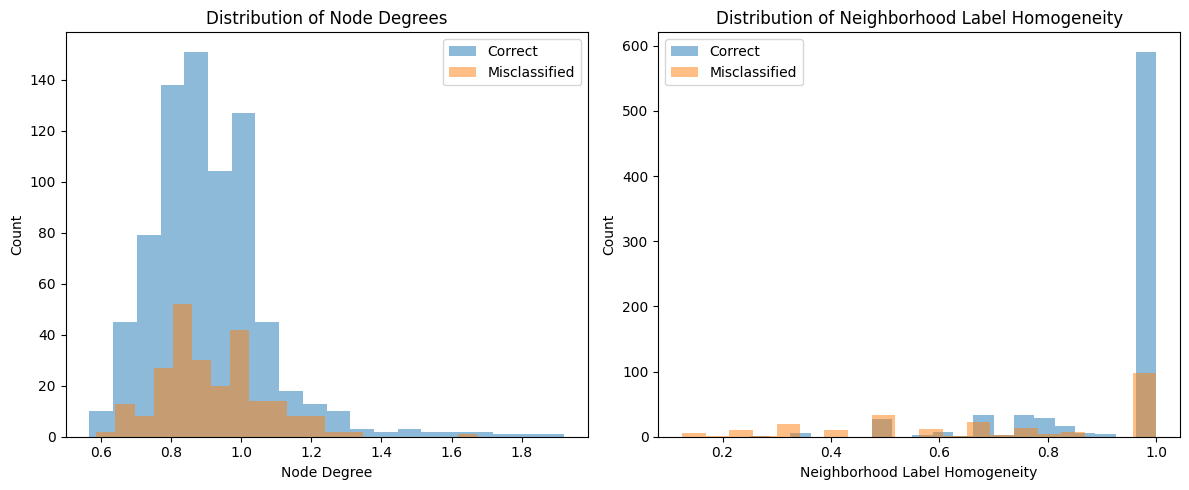

In [23]:
def analyze_misclassifications(model, features, adj, labels, idx_test):
    """
    Analyze misclassified nodes.
    
    Parameters
    ----------
    model : GCN
        The trained model
    features : torch.sparse.FloatTensor
        Input features
    adj : torch.sparse.FloatTensor
        Normalized adjacency matrix
    labels : torch.LongTensor
        Ground-truth labels
    idx_test : torch.LongTensor
        Indices of test nodes
    """
    model.eval()
    with torch.no_grad():
        # Get predictions
        output = model(features, adj)
        _, preds = output.max(1)
        
        # Find misclassified nodes
        misclassified = (preds != labels) & torch.zeros_like(labels).scatter_(0, idx_test, 1).bool()
        misclassified_idx = torch.where(misclassified)[0]
        
        print(f"Number of misclassified test nodes: {misclassified_idx.size(0)} out of {len(idx_test)} ({100 * misclassified_idx.size(0) / len(idx_test):.2f}%)")
        
        # Get degree of each node
        if hasattr(adj, 'to_dense'):
            adj_dense = adj.to_dense()
        else:
            adj_dense = adj
        degrees = adj_dense.sum(1)
        
        # Compute average degree of correctly and incorrectly classified nodes
        correct = (preds == labels) & torch.zeros_like(labels).scatter_(0, idx_test, 1).bool()
        correct_idx = torch.where(correct)[0]
        
        avg_degree_correct = degrees[correct_idx].mean().item()
        avg_degree_incorrect = degrees[misclassified_idx].mean().item()
        
        print(f"Average degree of correctly classified nodes: {avg_degree_correct:.2f}")
        print(f"Average degree of misclassified nodes: {avg_degree_incorrect:.2f}")
        
        # Analyze neighborhood label homogeneity
        neighborhood_homogeneity_correct = []
        neighborhood_homogeneity_incorrect = []
        
        for idx in correct_idx:
            neighbors = torch.where(adj_dense[idx] > 0)[0]
            if len(neighbors) > 0:
                neighbor_labels = labels[neighbors]
                same_label = (neighbor_labels == labels[idx]).float().mean().item()
                neighborhood_homogeneity_correct.append(same_label)
        
        for idx in misclassified_idx:
            neighbors = torch.where(adj_dense[idx] > 0)[0]
            if len(neighbors) > 0:
                neighbor_labels = labels[neighbors]
                same_label = (neighbor_labels == labels[idx]).float().mean().item()
                neighborhood_homogeneity_incorrect.append(same_label)
        
        avg_homogeneity_correct = np.mean(neighborhood_homogeneity_correct)
        avg_homogeneity_incorrect = np.mean(neighborhood_homogeneity_incorrect)
        
        print(f"Average neighborhood label homogeneity of correctly classified nodes: {avg_homogeneity_correct:.2f}")
        print(f"Average neighborhood label homogeneity of misclassified nodes: {avg_homogeneity_incorrect:.2f}")
        
        # Visualize distribution of degrees
        plt.figure(figsize=(12, 5))
        
        plt.subplot(1, 2, 1)
        plt.hist(degrees[correct_idx].cpu().numpy(), alpha=0.5, bins=20, label='Correct')
        plt.hist(degrees[misclassified_idx].cpu().numpy(), alpha=0.5, bins=20, label='Misclassified')
        plt.xlabel('Node Degree')
        plt.ylabel('Count')
        plt.title('Distribution of Node Degrees')
        plt.legend()
        
        plt.subplot(1, 2, 2)
        plt.hist(neighborhood_homogeneity_correct, alpha=0.5, bins=20, label='Correct')
        plt.hist(neighborhood_homogeneity_incorrect, alpha=0.5, bins=20, label='Misclassified')
        plt.xlabel('Neighborhood Label Homogeneity')
        plt.ylabel('Count')
        plt.title('Distribution of Neighborhood Label Homogeneity')
        plt.legend()
        
        plt.tight_layout()
        plt.show()

# Analyze misclassifications
analyze_misclassifications(model, features, adj, labels, idx_test)

## 7. Summary and Conclusion

In this notebook, we've:
`
1. **Preprocessed the Cora dataset** for training a GCN model
2. **Implemented a complete training loop** with early stopping
3. **Evaluated the GCN model** on the test set
4. **Compared our GCN model** with several baseline methods
5. **Analyzed node misclassifications** to understand model limitations

Our findings show that:

- GCNs outperform models that use only features (MLP) or only graph structure (Label Propagation)
- The combination of features and graph structure leads to better performance
- Nodes with higher connectivity and surrounded by nodes of the same class are easier to classify

### Discussion Questions

1. Why do GCNs perform better than methods that use only features or only graph structure?
2. What are the limitations of semi-supervised learning on graphs?
3. How might we improve the GCN model to achieve better performance?
4. What kinds of nodes are most difficult for GCNs to classify correctly? Why?
5. How does the size of the training set affect the performance of GCNs?

In the next notebook, we'll explore more advanced techniques for visualizing and analyzing GCNs, as well as some extensions to the basic GCN model.